In [1]:
import os
import glob
import nibabel as nib
import numpy as np
import cv2
import math
import re

import matplotlib.pyplot as plt

In [2]:
data_path = "../data/all/"
os.listdir(data_path)

['VS-239-250',
 '.DS_Store',
 'VS-31-61',
 'VS-176-205',
 'VS-113-143',
 'VS-62-91',
 'README.md',
 'VS-206-238',
 'VS-1-30',
 'VS-144-175',
 'VS-92-112']

In [3]:
t1_list = sorted(glob.glob(os.path.join(data_path, "VS-*-*/vs_*/*_t1_*")))
t2_list = sorted(glob.glob(os.path.join(data_path, "VS-*-*/vs_*/*_t2_*")))
seg_list = sorted(glob.glob(os.path.join(data_path, "VS-*-*/vs_*/*_seg_*")))

In [4]:
import plotly.express as px
import json

In [12]:
model_path = "../models/correctionloss_64img_40size"
os.listdir(model_path)

['val_history.json',
 'training_files.csv',
 'validation_files.csv',
 'train_history.json',
 'best.pt',
 'checkpoint.pt',
 'architecture.txt']

In [13]:
with open(os.path.join(model_path, "train_history.json"), "r") as f:
    train_history = json.load(f)
with open(os.path.join(model_path, "val_history.json"), "r") as f:
    val_history = json.load(f)

In [14]:
fig = px.line({"loss": train_history["loss"], "val_loss": val_history["loss"]})
fig.show()

In [15]:
fig = px.line({"dice": train_history["dice"], "val_dice": val_history["dice"]})
fig.show()

In [16]:
import sys
import csv

sys.path.append("../")
from src.model.correction import CorrectionUnet
from src.model.segmentation import Unet
from src.data.correction_generator import CorrectionMRIDataset, CorrectionMRIDatasetSequences, CorrectionDataLoader
from src.data.data_generator import MRIDataset
from src.losses.dice import dice_coefficient

import torch

In [17]:
# Load used training files from csv
d = os.path.join(model_path, "training_files.csv")

used_files = []
with open(d) as file:
    training_files = csv.reader(file)
    used_files = [f for f in training_files]
used_files.pop(0)

['t1', ' t2', ' seg']

In [ ]:
# modify the loaded paths to match the local fs
pattern = r"VS-\d+-\d+/vs_\w+/\w+_seg_\w+\.nii\.gz"
modified_paths = [
    os.path.join(data_path, re.search(pattern, path[0]).group()) for path in used_files
]
modified_paths[:4]

In [ ]:
if len(modified_paths) > 64:
    modified_paths = modified_paths[:64]

In [ ]:
# extract testing files
testing_files = list(set(seg_list) - set(modified_paths))
len(testing_files)

In [21]:
# modify the loaded paths to match the local fs
pattern = r"VS-\d+-\d+/vs_\w+/\w+\w+\.nii\.gz"

used_t1 = []
used_t2 = []
used_seg = []

for paths in used_files:
    used_t1.append(os.path.join(data_path, re.search(r"VS-\d+-\d+/vs_\w+/\w+_t1_\w+\.nii\.gz", paths[0]).group()))
    used_t2.append(os.path.join(data_path, re.search(r"VS-\d+-\d+/vs_\w+/\w+_t2_\w+\.nii\.gz", paths[1]).group()))
    used_seg.append(os.path.join(data_path, re.search(r"VS-\d+-\d+/vs_\w+/\w+_seg_\w+\.nii\.gz", paths[2]).group()))

print(len(used_t1), len(used_t2), len(used_seg))
print(used_t1[:3])
print(used_t2[:3])
print(used_seg[:3])

t1_train = sorted(list(set(t1_list) - set(used_t1)))
t2_train = sorted(list(set(t2_list) - set(used_t2)))
seg_train = sorted(list(set(seg_list) - set(used_seg)))

print(len(t1_train), len(t2_train), len(seg_train))

64 64 64
['../data/all/VS-62-91/vs_gk_86/vs_gk_t1_refT2.nii.gz', '../data/all/VS-31-61/vs_gk_56/vs_gk_t1_refT2.nii.gz', '../data/all/VS-206-238/vs_gk_212/vs_gk_t1_refT2.nii.gz']
['../data/all/VS-62-91/vs_gk_86/vs_gk_t2_refT2.nii.gz', '../data/all/VS-31-61/vs_gk_56/vs_gk_t2_refT2.nii.gz', '../data/all/VS-206-238/vs_gk_212/vs_gk_t2_refT2.nii.gz']
['../data/all/VS-62-91/vs_gk_86/vs_gk_seg_refT2.nii.gz', '../data/all/VS-31-61/vs_gk_56/vs_gk_seg_refT2.nii.gz', '../data/all/VS-206-238/vs_gk_212/vs_gk_seg_refT2.nii.gz']
178 178 178


In [ ]:
data = CorrectionMRIDataset(
    testing_files,
    (256, 256),
    clicks={"num": 3, "dst": 10},
    cuts={
        "num": 12,
        "size": 32,
    },
    random=True, 
    augment=False,
    include_unchanged=False
    # seed=420
)

In [70]:
cuts_data = CorrectionMRIDatasetSequences(
    t1_train,
    t2_train,
    seg_train,
    (256, 256),
    clicks={"num": 3, "dst": 10},
    cuts={
        "num": 12,
        "size": 40,
    },
    random=True, 
    augment=False,
    include_unchanged=False
    # seed=420
)

In [71]:
data = MRIDataset(
    t1_train,
    t2_train,
    seg_train,
    (40, 256, 256),
    clicks=None,
    # seed=420
)

In [72]:
model = CorrectionUnet(in_channels=3, out_channels=1, blocks=3).to("mps")

checkpoint = torch.load(os.path.join(model_path, "best.pt"), map_location="mps")
model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

In [73]:
len(cuts_data)

178

In [74]:
def preview_cuts(pred: torch.Tensor, x: torch.Tensor, y: torch.Tensor, dice: float, epoch=0):
    """Plot batch of cuts."""
    
    rows = pred.shape[0]
    cols = 3
    res = cols if cols > rows else rows

    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res * 2, res * 2))
    axs = axs.flatten()
    j = 0

    for i in range(pred.shape[0]):
        tmp_cut = torch.clone(pred[i, 0, :, :])
        tmp_cut[pred.shape[2] // 2, pred.shape[2] // 2] = 2
        axs[j].imshow(tmp_cut.cpu().detach(), cmap="magma")
        axs[j].axis("off")
        axs[j].set_title(
            # f"correction dice={dice_coefficient(pred[i].unsqueeze(0), y[i].unsqueeze(0)).item():>5f}", 
            'Prediction',
            fontsize=9,
        )

        tmp_cut = torch.clone(x[i, 0, :, :])
        tmp_cut[pred.shape[2] // 2, pred.shape[2] // 2] = 2
        axs[j + 1].imshow(tmp_cut.cpu().detach(), cmap="magma")
        axs[j + 1].axis("off")
        axs[j + 1].set_title("Training cut", fontsize=9)

        tmp_cut = torch.clone(y[i, 0, :, :])
        tmp_cut[pred.shape[2] // 2, pred.shape[2] // 2] = 2
        axs[j + 2].imshow(tmp_cut.cpu().detach(), cmap="magma")
        axs[j + 2].axis("off")
        axs[j + 2].set_title("Original cut", fontsize=9)

        j += 3
    fig.suptitle(f"Dice: {dice}", fontsize=10)
    plt.subplots_adjust(top=0.9)
    plt.show()

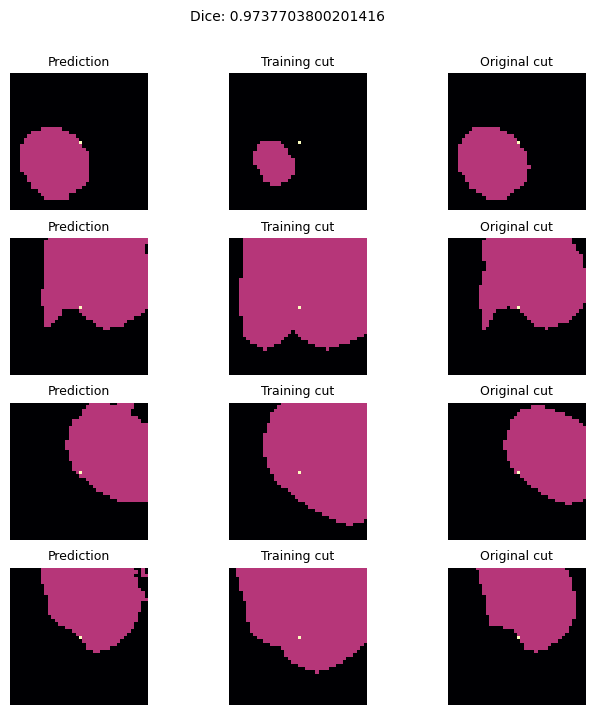

In [75]:
dataloader = CorrectionDataLoader(cuts_data, 4)
with torch.no_grad():
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to("mps"), y.to("mps")
        y_pred = model(x)
        y_threshed = (y_pred > 0.6).type(torch.float32)
        preview_cuts(y_threshed, x, y[:,0].unsqueeze(1), dice_coefficient(y_pred, y[:,0].unsqueeze(1)).item())
        break

In [78]:
testing_dice = []

dataloader = CorrectionDataLoader(cuts_data, 4)
with torch.no_grad():
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to("mps"), y.to("mps")
        y_pred = model(x)
        testing_dice.append(dice_coefficient(y_pred, y[:,0].unsqueeze(1)).item())
        # preview_cuts(y_pred, x, y[:,0].unsqueeze(1), dice_coefficient(y_pred, y[:,0].unsqueeze(1)).item())

In [79]:
# musi tam byt niekde chyba vo validacii mozno / alebo tam kde sa robi validacia
np.mean(testing_dice)

0.9498694134529099

In [82]:
model = Unet(in_channels=2, out_channels=1, blocks=3).to("cpu")

checkpoint = torch.load(os.path.join(model_path, "best.pt"), map_location="cpu")
model.load_state_dict(checkpoint["model_state"])

In [81]:
x, y = data[10]
x, y = x.to('cpu'), y.to('cpu')

In [40]:
with torch.no_grad():
    y_pred = model(x.unsqueeze(0))

In [43]:
def get_glioma_indices(mask: torch.Tensor) -> tuple[int, int]:
    glioma_indices = torch.nonzero((mask == 1))[:, 0]
    if len(glioma_indices) == 0:
        return 0, 0

    first = glioma_indices[0].item()
    last = glioma_indices[-1].item()

    return first, last


In [45]:
get_glioma_indices(y[0])

(20, 27)

Text(0.5, 1.0, 'Prediction')

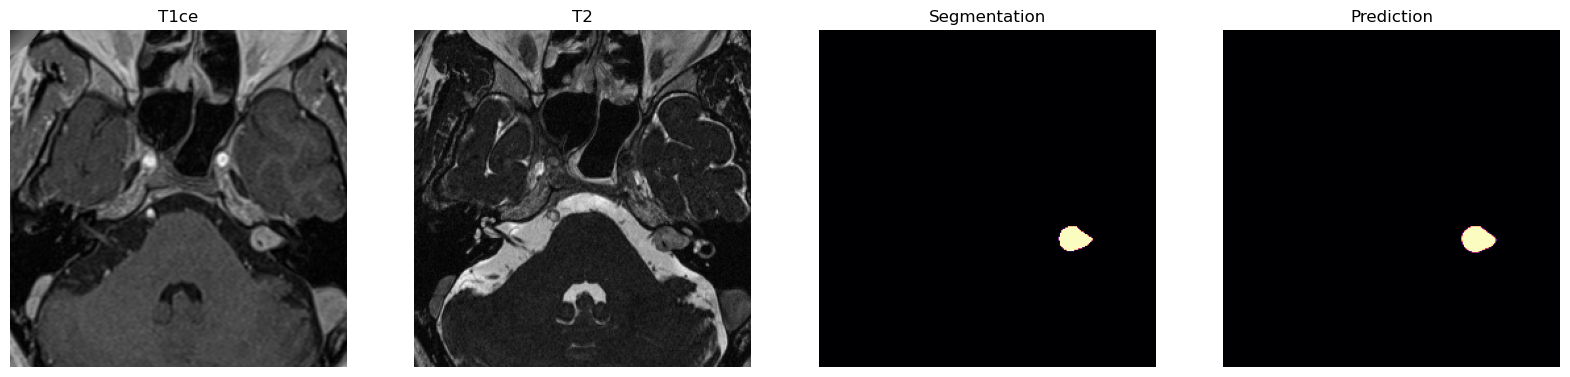

In [47]:
slice = 23
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
axs[0].imshow(torch.rot90(x[0, slice], 3), cmap="gray")
axs[0].axis("off")
axs[0].set_title("T1ce", fontsize=12)

axs[1].imshow(torch.rot90(x[1, slice], 3), cmap="gray")
axs[1].axis("off")
axs[1].set_title("T2", fontsize=12)

axs[2].imshow(torch.rot90(y[0, slice], 3), cmap="magma")
axs[2].axis("off")
axs[2].set_title("Segmentation", fontsize=12)

axs[3].imshow(torch.rot90(y_pred[0, 0, slice], 3), cmap="magma")
axs[3].axis("off")
axs[3].set_title("Prediction", fontsize=12)